In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('../')
import fn
from addition_dataset import GroupAddition

In [2]:
%load_ext autoreload
%autoreload 2

## Data Preparation

In [3]:
def prepare_data(b, depth, table, batch_size=16, num_passes=1000, split=0.9):
    
    # Get indices of training and testing data
    N = b**depth
    ids = random.sample(range(N), math.ceil(split * N))
    heldout_ids = set(range(N)) - set(ids)
    
    # Create training dataset and dataloader
    training_dataset = GroupAddition(table, depth, ids=ids, interleaved=True, digit_order='reversed')
    training_dataset = torch.utils.data.ConcatDataset([training_dataset] * num_passes)
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    
    # Create testing dataset and dataloader
    testing_dataset = GroupAddition(table, depth, ids=heldout_ids, interleaved=True, digit_order='reversed')
    testing_dataset = torch.utils.data.ConcatDataset([testing_dataset] * num_passes)
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

    return training_dataloader, testing_dataloader

## LSTM

## Definitions

### Model and loss function

In [4]:
# Define model
class LSTMModel(nn.Module):
    '''Simple LSTM model for testing purposes'''
    def __init__(self, b, hidden, layers):
        '''Initialize model with specified parameters'''
        super().__init__()
        self.b = b
        self.hidden = hidden
        self.layers = layers
        self.lstm = nn.LSTM(b, hidden, layers, batch_first=True)
        self.linear = nn.Linear(hidden, 1)

    def forward(self, X):
        '''Return forward-pass including missing values of X'''
        X_out, _ = self.lstm(X)
        X_out = self.linear(X_out).squeeze()
        return X_out

In [5]:
def prediction(X_out, ids):
    if X_out.dim() == 2:
        X_out_and_ids = zip(torch.unbind(X_out), torch.unbind(ids))
        s_out = torch.stack([X_out[ids] for X_out, ids in X_out_and_ids])
    else:
        s_out = X[ids]
    return s_out

In [6]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X_out, s, ids):
        MSE = nn.MSELoss()
        s_out = prediction(X_out, ids)
        loss = MSE(s_out, s)
        return loss

### Training and testing loops

In [7]:
def train(model, training_dataloader, print_losses=True):

    # Initialize variables
    losses = []
    t = 0

    # Training loop
    for batch_idx, (X, s, ids) in enumerate(training_dataloader):
        
        # Compute, store, and print loss
        loss = criterion(model(X), s.float(), ids)
        losses.append(loss.item())
        if print_losses and (t % 100 == 0):
            print(f't = {t}  loss = {loss.item():.6f}')
        
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Iterate counter
        t += 1

    return losses

In [8]:
# Test model
def test(model, testing_dataloader, print_accuracy=True):
    
    with torch.no_grad():
        
        # Set model to evaluation mode
        model.eval()
    
        # Perform evaluation
        total_correct = 0
        total_samples = 0
        for batch_idx, (X, s, ids) in enumerate(testing_dataloader):
    
            # Forward pass
            X_out = model(X)
            s_out = prediction(X_out, ids)
            s_out = torch.round(s_out)
    
            # Calculate accuracy
            total_correct += ((s_out == s).sum(1) == depth).sum().item()
            total_samples += batch_size
    
        accuracy = total_correct / total_samples
        if print_accuracy:
            print(f'Accuracy on testing set: {accuracy:.4f}')

### Visualization

In [35]:
def smooth(losses, size=10):
    kernel = np.ones(size) / size
    smoothed_losses = np.convolve(losses, kernel, mode='same')
    return smoothed_losses

In [48]:
def plot_loss(all_losses, size=10):
    if len(all_losses) > 1:
        alpha = 0.5
    for c, losses in all_losses.items():
        plt.plot(smooth(losses, size=size), alpha=alpha, label=sorted(c)[0])
    if len(all_losses) > 1:
        plt.legend()
    plt.title(f'Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.show()

## Execute

In [42]:
# Specify base, depth, and batch size
b = 5
depth = 3
batch_size = 16

# Get carry tables for base
with open('../pickles/all_tables.pickle', 'rb') as f:
    all_tables = pickle.load(f)
tables = all_tables[b]

# Train model for each table
all_losses = {}
for c, table in tables.items():

    # Get dataloaders
    training_dataloader, testing_dataloader = prepare_data(b, depth, table, batch_size=batch_size)
    
    # Initialize model
    model = LSTMModel(b, b, 2)
    
    # Define criterion and optimizer
    criterion = Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train and test model
    losses = train(model, training_dataloader, print_losses=False)
    print(c)
    test(model, testing_dataloader, print_accuracy=True)
    print()
    all_losses[c] = losses

((0, 0, 2, 2, 4), (0, 1, 4, 0, 3), (0, 2, 1, 3, 2), (0, 3, 3, 1, 1), (0, 4, 0, 4, 0))
Accuracy on testing set: 0.9621

((0, 0, 4, 3, 2), (0, 1, 1, 1, 1), (0, 2, 3, 4, 0), (0, 3, 0, 2, 4), (0, 4, 2, 0, 3))
Accuracy on testing set: 0.9673

((0, 0, 0, 3, 3), (0, 1, 2, 1, 2), (0, 2, 4, 4, 1), (0, 3, 1, 2, 0), (0, 4, 3, 0, 4))
Accuracy on testing set: 0.9858

((0, 0, 0, 0, 0), (0, 1, 2, 3, 4), (0, 2, 4, 1, 3), (0, 3, 1, 4, 2), (0, 4, 3, 2, 1))
Accuracy on testing set: 0.9651



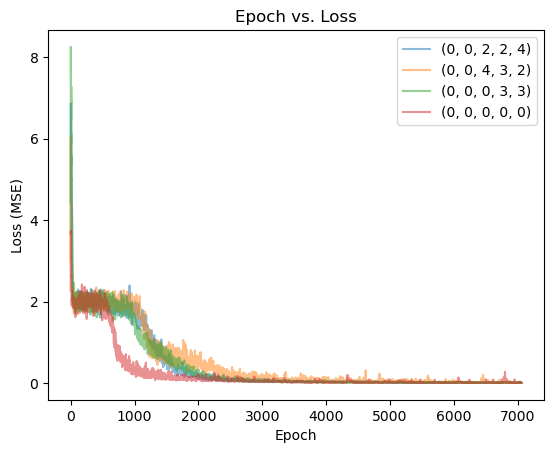

In [49]:
# Plot losses
plot_loss(all_losses, size=4)

## Transformer